# CNN

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()  

X_train, X_test, y_train, y_test = train_test_split(digits.images, digits.target, test_size=0.2, random_state=42)

print(X_train.shape)

(1437, 8, 8)


In [4]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([145, 154, 144, 149, 135, 135, 146, 145, 144, 140]))

(8, 8)


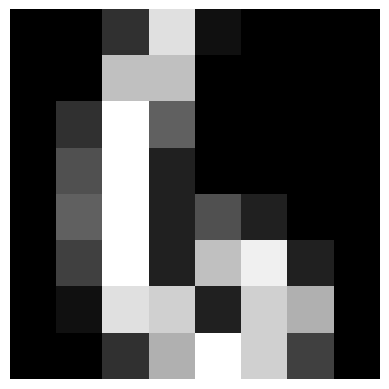

In [5]:
print(X_train[0].shape) # H, W
plt.imshow(X_train[0], cmap='gray');
plt.axis('off')
plt.show()

In [6]:
class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_h, self.kernel_w = kernel_size
        self.stride = stride
        self.padding = padding

        scale = np.sqrt(2 / (in_channels * kernel_size[0] * kernel_size[1])) # для стандартизации весов
        self.W = np.random.randn(out_channels, in_channels, self.kernel_h, self.kernel_w) * scale
        self.b = np.zeros(out_channels)

        # Для backward сохраняем x с padding
        self.x_padded = None

    def forward(self, x):
        C, H, W = x.shape # (входные каналы, входные размеры)

        # Добавляем padding
        if self.padding > 0:
            self.x_padded = np.pad(x, ((0,0), (self.padding, self.padding), (self.padding, self.padding)), 'constant')
        else:
            self.x_padded = x

        H, W = self.x_padded.shape[1], self.x_padded.shape[2]
        # Размер выхода
        out_h = (H - self.kernel_h) // self.stride + 1
        out_w = (W - self.kernel_w) // self.stride + 1
        # Выходной тензор
        out = np.zeros((self.out_channels, out_h, out_w))

        for oc in range(self.out_channels):           
            for i in range(out_h):
                for j in range(out_w):
                    h_start = i * self.stride
                    w_start = j * self.stride
                    window = self.x_padded[:, h_start:h_start + self.kernel_h, w_start:w_start + self.kernel_w]
                    out[oc, i, j] = np.sum(window * self.W[oc]) + self.b[oc]

        return out

    def backward(self, dout, learning_rate=0.01):
        oc, out_h, out_w = dout.shape # (выходные каналы, выходные размеры)

        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        dx_padded = np.zeros_like(self.x_padded)

        for oc_idx in range(self.out_channels):
            for i in range(out_h):
                for j in range(out_w):
                    h_start = i * self.stride
                    w_start = j * self.stride

                    window = self.x_padded[:, h_start:h_start + self.kernel_h, w_start:w_start + self.kernel_w]

                    # Градиенты по весам и смещениям
                    self.dW[oc_idx] += window * dout[oc_idx, i, j]
                    self.db[oc_idx] += dout[oc_idx, i, j]

                    # Градиент по входу
                    dx_padded[:, h_start:h_start + self.kernel_h, w_start:w_start + self.kernel_w] += \
                        self.W[oc_idx] * dout[oc_idx, i, j]

        # Обрезаем padding
        if self.padding > 0:
            dx = dx_padded[:, self.padding:-self.padding, self.padding:-self.padding]
        else:
            dx = dx_padded

        return dx

In [7]:
class MaxPooling:
    def __init__(self, kernel_size, stride=2):
        self.kernel_h, self.kernel_w = kernel_size
        self.stride = stride
        self.x = None

    def forward(self, x):
        self.x = x
        C, H, W = x.shape
        out_h = (H - self.kernel_h) // self.stride + 1
        out_w = (W - self.kernel_w) // self.stride + 1
        out = np.zeros((C, out_h, out_w))

        for c in range(C):
            for i in range(out_h):
                for j in range(out_w):
                    h_start = i * self.stride
                    w_start = j * self.stride
                    window = x[c, h_start:h_start + self.kernel_h, w_start:w_start + self.kernel_w]
                    out[c, i, j] = np.max(window)

        return out

    def backward(self, dout):
        C, out_h, out_w = dout.shape
        _, H, W = self.x.shape
        dx = np.zeros_like(self.x) # здесь сохраняем градиенты для входов

        for c in range(C):
            for i in range(out_h):
                for j in range(out_w):
                    h_start = i * self.stride
                    w_start = j * self.stride
                    window = self.x[c, h_start:h_start + self.kernel_h, w_start:w_start + self.kernel_w]
                    max_val = np.max(window)
                    mask = (window == max_val) # создаем маску где максимальное значение будет 1, а остальные нулями
                    dx[c, h_start:h_start + self.kernel_h, w_start:w_start + self.kernel_w] += mask * dout[c, i, j] # где содержится максимальное значение, туда и записываем градиент, так как остальные значения не влияли на следующие слои

        return dx

In [8]:
class ReLU:
    def forward(self, x):
        self.x = x
        return np.maximum(0, self.x)
    def backward(self, dout):
        d_x = dout.copy()
        d_x = d_x * (self.x > 0) # обнуляем градиент там, где он нейрон был неактивен
        return d_x

In [9]:
class Flatten:
    def forward(self, x):
        self.input_shape = x.shape
        return x.reshape(-1)
    
    def backward(self, dout):
        return dout.reshape(self.input_shape) # возвращаем исходную форму

In [10]:
class Softmax:
    def forward(self, x):
        ex = np.exp(x - np.max(x))                      
        return ex / np.sum(ex)  
    
    def backward(self, dout):
        return dout.copy()

In [11]:
class Dense:
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs
        scale = np.sqrt(2 / inputs)
        self.W = np.random.randn(inputs, outputs) * scale
        self.b = np.zeros(outputs)
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b
    
    def backward(self, dout):
        self.dW = np.outer(self.x, dout) # (inputs, outputs)
        self.db = dout.copy() # (outputs,)

        dx = dout @ self.W.T # (inputs,)

        return dx

In [18]:
conv1 = Conv2D(in_channels=1,   out_channels=4, kernel_size=(3,3), stride=1, padding=1)   
relu1 = ReLU()
conv2 = Conv2D(in_channels=4,  out_channels=8, kernel_size=(3,3), stride=1, padding=1)   
relu2 = ReLU()
pool1 = MaxPooling(kernel_size=(2,2), stride=2)                                               
flatten = Flatten()
dense   = Dense(inputs=128, outputs=10) 
softmax = Softmax()

dW_conv1 = np.zeros_like(conv1.W)
db_conv1 = np.zeros_like(conv1.b)
dW_conv2 = np.zeros_like(conv2.W)
db_conv2 = np.zeros_like(conv2.b)

dW_dense = np.zeros_like(dense.W)
db_dense = np.zeros_like(dense.b)

n_samples = len(X_train)

for epoch in range(20):
    total_correct = 0
    total_loss = 0.0

    indices = np.random.permutation(n_samples)
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]

    # Обнуляем накопители в начале каждой эпохи
    dW_conv1.fill(0); db_conv1.fill(0)
    dW_conv2.fill(0); db_conv2.fill(0)
    dW_dense.fill(0); db_dense.fill(0)

    for img, label in zip(X_train, y_train):
        x = img[np.newaxis, :, :].astype(np.float32) / 255.0   # (1,8,8)

        x = conv1.forward(x)
        x = relu1.forward(x)
        x = conv2.forward(x)
        x = relu2.forward(x)
        x = pool1.forward(x)
        x = flatten.forward(x)           
        x = dense.forward(x)             
        probs = softmax.forward(x)

        pred = np.argmax(probs)
        if pred == label:
            total_correct += 1
        total_loss -= np.log(probs[label] + 1e-15)

        dout = probs - np.eye(10)[label] 
        dout = dense.backward(dout)
        dout = flatten.backward(dout)    
        dout = pool1.backward(dout)
        dout = relu2.backward(dout)
        dout = conv2.backward(dout)
        dout = relu1.backward(dout)
        _    = conv1.backward(dout)

        lr = 0.005 if epoch < 10 else 0.001    
        conv1.W -= lr * conv1.dW
        conv1.b -= lr * conv1.db
        conv2.W -= lr * conv2.dW
        conv2.b -= lr * conv2.db
        dense.W -= lr * dense.dW
        dense.b -= lr * dense.db

    print(f"Epoch {epoch+1:2d}  Accuracy: {total_correct/n_samples:.5f}  Loss: {total_loss/n_samples:.4f}")

Epoch  1  Accuracy: 0.12317  Loss: 2.2810
Epoch  2  Accuracy: 0.23104  Loss: 2.2387
Epoch  3  Accuracy: 0.37509  Loss: 2.1332
Epoch  4  Accuracy: 0.54349  Loss: 1.8287
Epoch  5  Accuracy: 0.73347  Loss: 1.2116
Epoch  6  Accuracy: 0.80654  Loss: 0.7448
Epoch  7  Accuracy: 0.84690  Loss: 0.5445
Epoch  8  Accuracy: 0.86917  Loss: 0.4404
Epoch  9  Accuracy: 0.88866  Loss: 0.3744
Epoch 10  Accuracy: 0.90188  Loss: 0.3281
Epoch 11  Accuracy: 0.92763  Loss: 0.2642
Epoch 12  Accuracy: 0.93111  Loss: 0.2537
Epoch 13  Accuracy: 0.93528  Loss: 0.2472
Epoch 14  Accuracy: 0.93807  Loss: 0.2411
Epoch 15  Accuracy: 0.93807  Loss: 0.2355
Epoch 16  Accuracy: 0.93807  Loss: 0.2303
Epoch 17  Accuracy: 0.93946  Loss: 0.2254
Epoch 18  Accuracy: 0.94015  Loss: 0.2208
Epoch 19  Accuracy: 0.94085  Loss: 0.2165
Epoch 20  Accuracy: 0.94224  Loss: 0.2123


In [19]:
total_correct = 0
total_loss = 0.0
n_samples = len(X_test)
for img, label in zip(X_test, y_test):
    x = img[np.newaxis, :, :].astype(np.float32) / 255.0   # (1,8,8)

    x = conv1.forward(x)
    x = relu1.forward(x)
    x = conv2.forward(x)
    x = relu2.forward(x)
    x = pool1.forward(x)
    x = flatten.forward(x)           
    x = dense.forward(x)             
    probs = softmax.forward(x)

    pred = np.argmax(probs)
    if pred == label:
        total_correct += 1
    total_loss -= np.log(probs[label] + 1e-15)

print(f"Accuracy: {total_correct/n_samples:.5f}  Loss: {total_loss/n_samples:.4f}")

Accuracy: 0.92500  Loss: 0.2196


In [27]:
import matplotlib.pyplot as plt

def show_filters(conv):
    W = conv.W
    out_channels, in_channels, kh, kw = W.shape

    fig, ax = plt.subplots(out_channels, in_channels, figsize=(in_channels*2, out_channels*2))

    if out_channels == 1 and in_channels == 1:
        ax = np.array([[ax]])
    elif out_channels == 1:
        ax = np.array([ax])
    elif in_channels == 1:
        ax = np.array([[a] for a in ax])

    for oc in range(out_channels):
        for ic in range(in_channels):
            ax[oc, ic].imshow(W[oc, ic], cmap='gray')
            ax[oc, ic].set_title(f"Out {oc}, In {ic}")
            ax[oc, ic].axis('off')

    plt.show()


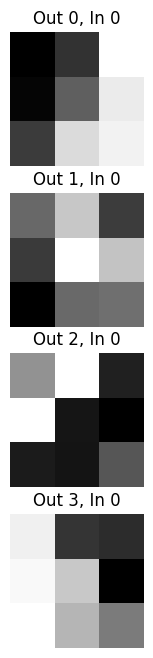

In [28]:
show_filters(conv1)